# StarGAN CelebA

This notebook is for implementing `StarGAN` from the paper [StarGAN: Unified Generative Adversarial Networks for Multi-Domain Image-to-Image Translation](https://arxiv.org/abs/1711.09020) with [Tensorflow](https://www.tensorflow.org). <br>
[CelebA dataset](https://www.kaggle.com/jessicali9530/celeba-dataset), which is 128x128 size, will be used. 

Reference: [hwalsuklee's Github](https://github.com/hwalsuklee/tensorflow-generative-model-collections)

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## Import Libraries

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import glob
import cv2 
import datetime

/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/frame

## Parameters


In [3]:
algorithm = 'StarGAN_CelebA'

img_size   = 128

batch_size = 32
num_epoch  = 5

beta1 = 0
beta2 = 0.9

learning_rate_g = 0.0001
learning_rate_d = 0.0001

attribute_size = 12

show_result_step = 250

gpu_fraction = 0.9 

date_time = datetime.datetime.now().strftime("%Y%m%d-%H-%M-%S")

load_model = True
train_model = False

save_path = "./saved_models/" + date_time + "_" + algorithm
load_path = "./saved_models/20190830-13-33-06_StarGAN_CelebA/model/model" 

# WGAN_GP Parateter
n_critic = 1
d_lambda = 10 

# StarGAN Parameter
lambda_cls = 500
lambda_rec = 0.005

## Import CelebA Dataset

Get names of the files in the celeba dataset folder.

In [4]:
celebA_list = glob.glob('./img_align_celeba/*.jpg')
celebA_list.sort()
celebA_idx_list = np.arange(len(celebA_list))

print("CelebA dataset Length: {}".format(len(celebA_list)))

CelebA dataset Length: 202599


## Get CelebA Attribute

In [5]:
txt_file = open("list_attr_celeba.txt",'r')
contents = txt_file.readlines()
lines = [x.strip() for x in contents]

## Get Attribute Function

In [6]:
def Get_Attribute(idx):
    new_attr_idx_list = [4, 8, 9, 11, 15, 17, 18, 20, 24, 31, 35, 39]
    
    attribute_temp_str = lines[idx+2]
    attribute_temp_split = attribute_temp_str.split(' ')

    attribute_temp = np.zeros([1,img_size,img_size,attribute_size])
    attr_original = np.zeros([1, 40])
    
    count = 0
    for s in attribute_temp_split:  
        if s == '-1':
            attr_original[0,count] = 0
            count += 1

        if s == '1':
            attr_original[0,count] = 1
            count += 1
    
    for i in range(len(new_attr_idx_list)):
        if attr_original[0,new_attr_idx_list[i]] == 1:
            attribute_temp[:,:,:,i] = 1
        else:
            attribute_temp[:,:,:,i] = 0
    
    return attribute_temp

## Check Attribute

0: 5_o_Clock_Shadow / 
1: Arched Eyerbrows / 
2: Attractive / 
3: Bags Under Eyes / 
4: Bald / 
5: Bangs / 
6: Big Lips / 
7: Big Nose / 
8: Black Hair / 
9: Blond Hair / 
10: Blurry / 
11: Brown Hair / 
12: Bushy Eyebrows / 
13: Chubby / 
14: Double Chin / 
15: Eyeglasses / 
16: Goatee / 
17: Gray Hair / 
18: Heavy Makeup / 
19: High Cheekbones / 
20: Male / 
21: Mouth Slightly Open / 
22: Mustache / 
23: Narrow Eyes / 
24: No Beard / 
25: Oval Face / 
26: Pale Skin / 
27: Pointy Nose / 
28: Receding Hairline / 
29: Rosy Cheeks / 
30: Sideburns / 
31: Smiling / 
32: Straight Hair / 
33: Wavy Hair / 
34: Wearing Earrings / 
35: Wearing Hat / 
36: Wearing Lipstic / 
37: Wearing Necklace / 
38: Wearing Necktie / 
39: Young

Blond Hair
Heavy Makeup
No beard
Young


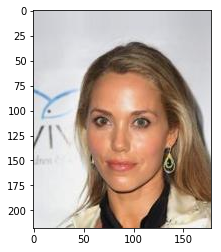

In [7]:
attr_list = ['5_o Clock Shadow', 'Arched Eyebrows', 'Attractive', 'Bags Under Eyes', 'Bald', 'Bangs', 'Big Lips', 'Big Nose',
             'Black Hair', 'Blond Hair', 'Blurry', 'Brown Hair', 'Bushy Eyebrows', 'Chubby', 'Double Chin', 'Eyeglasses', 'Goatee',
             'Gray Hair', 'Heavy Makeup', 'High Cheekbones', 'Male', 'Mouth Slightly Open', 'Mustache', 'Narrow Eyes', 'No beard',
             'Oval Face', 'Pale Skin', 'Pointy Nose', 'Receding Hairline', 'Rosy Cheeks', 'Sideburns', 'Smiling', 'Straight Hair',
             'Wavy Hair', 'Wearing Earrings', 'Wearing Hat', 'Wearing Lipstic', 'Wearing Necklace', 'Wearing Necktie', 'Young']

attr_list_new = ['Bald', 'Black Hair', 'Blond Hair', 'Brown Hair', 'Eyeglasses', 'Gray Hair', 'Heavy Makeup', 'Male',
                 'No beard', 'Smiling', 'Wearing Hat', 'Young']

idx_sample = np.random.randint(len(celebA_list))
idx_temp = celebA_idx_list[idx_sample]
img_sample = cv2.imread(celebA_list[idx_temp])
img_sample_RGB = cv2.cvtColor(img_sample, cv2.COLOR_BGR2RGB)

attribute_temp = Get_Attribute(idx_sample)        

plt.imshow(img_sample_RGB)

for i in range(len(attribute_temp[0,0,0,:])):
    if attribute_temp[0,0,0,i] == 1:
        print(attr_list_new[i])

## Generator

In [8]:
def ResNet(x, is_training, network_name):
        
    h = tf.layers.conv2d(x, filters=512, kernel_size=3, strides=1, padding='SAME', name=network_name+'_1')
    h = tf.contrib.layers.instance_norm(h)
    h = tf.nn.relu(h)
    h = tf.layers.conv2d(h, filters=512, kernel_size=3, strides=1, padding='SAME', name=network_name+'_2')
    h = tf.contrib.layers.instance_norm(h)
    h = x + h 
    h = tf.nn.relu(h)
    
    return h

def Generator(x, is_training, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        # First Conv (c7s1-32)
        e1 = tf.layers.conv2d(x, filters=64, kernel_size=7, strides=1, padding='SAME')
        e1 = tf.contrib.layers.instance_norm(e1)
        e1 = tf.nn.leaky_relu(e1)

        # Second Conv (d64)
        e2 = tf.layers.conv2d(e1, filters=128, kernel_size=3, strides=2, padding='SAME')
        e2 = tf.contrib.layers.instance_norm(e2)
        e2 = tf.nn.relu(e2)

        # Third Conv (d128)
        e3 = tf.layers.conv2d(e2, filters=256, kernel_size=3, strides=2, padding='SAME')
        e3 = tf.contrib.layers.instance_norm(e3)
        e3 = tf.nn.relu(e3)


        # Third Conv (d128)
        e4 = tf.layers.conv2d(e3, filters=256, kernel_size=3, strides=2, padding='SAME')
        e4 = tf.contrib.layers.instance_norm(e4)
        e4 = tf.nn.relu(e4)


        # Third Conv (d128)
        e5 = tf.layers.conv2d(e4, filters=256, kernel_size=3, strides=2, padding='SAME')
        e5 = tf.contrib.layers.instance_norm(e5)
        e5 = tf.nn.relu(e5)


        # Third Conv (d128)
        e6 = tf.layers.conv2d(e5, filters=512, kernel_size=3, strides=2, padding='SAME')
        e6 = tf.contrib.layers.instance_norm(e6)
        e6 = tf.nn.relu(e6)


        # Third Conv (d128)
        e7 = tf.layers.conv2d(e6, filters=512, kernel_size=3, strides=2, padding='SAME')
        e7 = tf.contrib.layers.instance_norm(e7)
        e7 = tf.nn.relu(e7)

        # Third Conv (d128)
        e8 = tf.layers.conv2d(e7, filters=512, kernel_size=3, strides=2, padding='SAME')
        e8 = tf.contrib.layers.instance_norm(e8)
        e8 = tf.nn.relu(e8)

        # ResNet Blocks (R128)
        r1 = ResNet(e8, is_training, 'resnet1')
        r2 = ResNet(r1, is_training, 'resnet2')
        r3 = ResNet(r2, is_training, 'resnet3')
        r4 = ResNet(r3, is_training, 'resnet4')
        r5 = ResNet(r4, is_training, 'resnet5')
        r6 = ResNet(r5, is_training, 'resnet6')
        r7 = ResNet(r6, is_training, 'resnet7')
        r8 = ResNet(r7, is_training, 'resnet8')
        r9 = ResNet(r8, is_training, 'resnet9')

        # FIrst Deconv Layer (u64)
        d1 = tf.layers.conv2d_transpose(r9,filters=512, kernel_size=3, strides=2, padding='SAME')
        d1 = tf.contrib.layers.instance_norm(d1)
        d1 = tf.nn.relu(d1)
        d1 = tf.concat([d1, e7], 3)

        d2 = tf.layers.conv2d_transpose(d1,filters=512, kernel_size=3, strides=2, padding='SAME')
        d2 = tf.contrib.layers.instance_norm(d2)
        d2 = tf.nn.relu(d2)
        d2 = tf.concat([d2, e6], 3)

        d3 = tf.layers.conv2d_transpose(d2,filters=512, kernel_size=3, strides=2, padding='SAME')
        d3 = tf.contrib.layers.instance_norm(d3)
        d3 = tf.nn.relu(d3)
        d3 = tf.concat([d3, e5], 3)

        d4 = tf.layers.conv2d_transpose(d3,filters=256, kernel_size=3, strides=2, padding='SAME')
        d4 = tf.contrib.layers.instance_norm(d4)
        d4 = tf.nn.relu(d4)
        d4 = tf.concat([d4, e4], 3)

        d5 = tf.layers.conv2d_transpose(d4,filters=256, kernel_size=3, strides=2, padding='SAME')
        d5 = tf.contrib.layers.instance_norm(d5)
        d5 = tf.nn.relu(d5)
        d5 = tf.concat([d5, e3], 3)

        d6 = tf.layers.conv2d_transpose(d5,filters=128, kernel_size=3, strides=2, padding='SAME')
        d6 = tf.contrib.layers.instance_norm(d6)
        d6 = tf.nn.relu(d6)
        d6 = tf.concat([d6, e2], 3)

        d7 = tf.layers.conv2d_transpose(d6,filters=64, kernel_size=3, strides=2, padding='SAME')
        d7 = tf.contrib.layers.instance_norm(d7)
        d7 = tf.nn.relu(d7)
        d7 = tf.concat([d7, e1], 3)

        # Last Conv (c7s1-3)       
        output = tf.tanh(tf.layers.conv2d(d7, filters=3, kernel_size=3, strides=1, padding='SAME')) 

        return output

## Discriminator

In [9]:
def Discriminator(x, is_training, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        # Hidden layer
        conv1 = tf.layers.conv2d(inputs=x,filters=64,activation=tf.nn.leaky_relu,kernel_size=[4,4],strides=[2,2],padding="SAME")
        conv2 = tf.layers.conv2d(inputs=conv1,filters=128,activation=tf.nn.leaky_relu,kernel_size=[4,4],strides=[2,2],padding="SAME")
        conv3 = tf.layers.conv2d(inputs=conv2,filters=256,activation=tf.nn.leaky_relu,kernel_size=[4,4],strides=[2,2],padding="SAME")
        conv4 = tf.layers.conv2d(inputs=conv3,filters=512,activation=tf.nn.leaky_relu,kernel_size=[4,4],strides=[2,2],padding="SAME")
        conv5 = tf.layers.conv2d(inputs=conv4,filters=1024,activation=tf.nn.leaky_relu,kernel_size=[4,4],strides=[2,2],padding="SAME")
        conv6 = tf.layers.conv2d(inputs=conv5,filters=2048,activation=tf.nn.leaky_relu,kernel_size=[4,4],strides=[2,2],padding="SAME")

        # Output layer
        out_src = tf.layers.conv2d(inputs=conv6,filters=1,activation=None,kernel_size=[2,2],strides=[2,2],padding="SAME")
        out_cls = tf.layers.conv2d(inputs=conv6,filters=attribute_size,activation=None,kernel_size=[2,2],strides=[2,2],padding="SAME")

        logit_src = tf.reshape(out_src, (-1, out_src.get_shape()[1]*out_src.get_shape()[2]*out_src.get_shape()[3]))
        logit_cls = tf.reshape(out_cls, (-1, out_cls.get_shape()[1]*out_cls.get_shape()[2]*out_cls.get_shape()[3]))

        return logit_src, logit_cls

## GAN

In [10]:
def GAN(x, attr_origin, attr_target, is_training):

    x_G_target = tf.concat([x, attr_target], 3)
    
    y_origin = tf.slice(attr_origin, [0, 0, 0, 0], [-1, 1, 1, -1])
    y_target = tf.slice(attr_target, [0, 0, 0, 0], [-1, 1, 1, -1])
    
    y_origin = tf.reshape(y_origin, (-1, attribute_size))
    y_target = tf.reshape(y_target, (-1, attribute_size))
    
    # Generator
    G = Generator(x_G_target, is_training)
    
    # Discriminator
    D_src_real, D_cls_real = Discriminator(x, is_training)
    D_src_fake, D_cls_fake = Discriminator(G, is_training, reuse=True)    

    # Domain Classification Loss 
    L_cls_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_origin, logits=D_cls_real))
    L_cls_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_target, logits=D_cls_fake))
    
    # Reconstruction Loss 
    x_G_origin = tf.concat([G, attr_origin], 3)
    
    G_r = Generator(x_G_origin, is_training, reuse=True)
    L_rec = tf.reduce_mean(tf.abs(G_r - x))
    
    # Adversarial Loss 
    ########################################### WGAN GP ###########################################
    eps = tf.random_uniform(shape=tf.shape(x),minval=0.0, maxval=1.0)
    x_hat = (eps * x) + ((1-eps) * G)
    D_hat, _ = Discriminator(x_hat, is_training, reuse=True)
    grad = tf.gradients(D_hat, [x_hat])[0]
    GP = d_lambda * tf.square(tf.norm(grad, ord=2) - 1)
    ###############################################################################################
    
    d_loss = -tf.reduce_mean(D_src_real) + tf.reduce_mean(D_src_fake) + GP + (lambda_cls * L_cls_real)
    g_loss = -tf.reduce_mean(D_src_fake) + (lambda_cls * L_cls_fake) + (lambda_rec * L_rec)
    
    cls_loss_real = lambda_cls * L_cls_real 
    cls_loss_fake = lambda_cls * L_cls_fake
    rec_loss = lambda_rec * L_rec
    
    return d_loss, g_loss , G, cls_loss_real, cls_loss_fake, rec_loss

## Build Graph

In [11]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, 3])
x_normalize = (tf.cast(x, tf.float32) - (255.0/2)) / (255.0/2)

attr_origin = tf.placeholder(tf.float32, shape=[None, img_size, img_size, attribute_size])
attr_target   = tf.placeholder(tf.float32, shape=[None, img_size, img_size, attribute_size])

is_training = tf.placeholder(tf.bool)

d_loss, g_loss, G, cls_loss_real, cls_loss_fake, rec_loss = GAN(x_normalize, attr_origin, attr_target, is_training) 

# optimization
trainable_variables = tf.trainable_variables()

trainable_variables_d = [var for var in trainable_variables if var.name.startswith('Discriminator')]
trainable_variables_g = [var for var in trainable_variables if var.name.startswith('Generator')]

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step_d = tf.train.AdamOptimizer(learning_rate_d, beta1, beta2).minimize(d_loss, var_list=trainable_variables_d)
    train_step_g = tf.train.AdamOptimizer(learning_rate_g, beta1, beta2).minimize(g_loss, var_list=trainable_variables_g)

## Initialization

In [12]:
# Initialize variables
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = gpu_fraction

sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

## Load Model

In [13]:
Saver = tf.train.Saver()

if load_model == True:
    Saver.restore(sess, load_path)

INFO:tensorflow:Restoring parameters from ./saved_models/20190830-13-33-06_StarGAN_CelebA/model/model


## Train

In [14]:
if train_model:
    # Training
    len_data = len(celebA_list)

    count_step = 0 

    for i in range(num_epoch):
        # Shuffle the data 
        np.random.shuffle(celebA_idx_list)

        # Making mini-batch
        for j in range(0, len_data, batch_size): 
            if j + batch_size < len_data:
                data_x_in = np.zeros([batch_size, img_size, img_size, 3])
                attr_origin_ = np.zeros([batch_size, img_size, img_size, attribute_size])
                attr_target_ = np.zeros([batch_size, img_size, img_size, attribute_size])

                for k in range(batch_size):
                    idx_temp = celebA_idx_list[j+k]
                    img_temp = cv2.imread(celebA_list[idx_temp])
                    data_x_in[k,:,:,:] = img_temp[45:45 + img_size, 25: 25+img_size, :]

                    attribute_temp = Get_Attribute(idx_temp)        
                    attr_origin_[k,:,:,:] = attribute_temp

                    target_idx_temp = np.random.randint(len(celebA_list))
                    attribute_temp = Get_Attribute(idx_temp) 
                    attr_target_[k,:,:,:] = attribute_temp

            # Run Optimizer!
            _, loss_d, loss_cls_real = sess.run([train_step_d, d_loss, cls_loss_real], 
                                                feed_dict = {x: data_x_in, 
                                                             attr_origin: attr_origin_, 
                                                             attr_target: attr_target_, 
                                                             is_training: True})

            _, loss_g, loss_cls_fake, loss_rec = sess.run([train_step_g, g_loss, cls_loss_fake, rec_loss], 
                                                           feed_dict = {x: data_x_in, 
                                                                        attr_origin: attr_origin_, 
                                                                        attr_target: attr_target_, 
                                                                        is_training: True})

            print ("Batch: {} / {}".format(j,len_data), end="\r")

            if count_step % show_result_step == 0 and count_step != 0:
                # Print Progess
                print("Epoch: {} / Batch: {:.3f}% / G Loss: {:.5f} / D Loss: {:.5f} / CLS Loss real: {:.5f} / CLS Loss fake: {:.5f} / Rec Loss: {:.8f}".format(
                     (i+1), (j/len_data), loss_g, loss_d, loss_cls_real, loss_cls_fake, loss_rec))

                # Show test images            
                origin_idx = np.random.randint(len(celebA_list))
                target_idx = np.random.randint(len(celebA_list))

                data_x_test = np.zeros([1, img_size, img_size, 3])
                attr_origin_test = np.zeros([1, img_size, img_size, attribute_size])
                attr_target_test = np.zeros([1, img_size, img_size, attribute_size])

                img_temp = cv2.imread(celebA_list[origin_idx])
                data_x_test[0,:,:,:] = img_temp[45:45 + img_size, 25: 25+img_size, :]

                attribute_origin_temp = Get_Attribute(origin_idx)        
                attr_origin_test[0,:,:,:] = attribute_origin_temp

                attribute_target_temp = Get_Attribute(target_idx) 
                attr_target_test[0,:,:,:] = attribute_target_temp

                G_out = sess.run(G, feed_dict = {x: data_x_test, attr_origin: attr_origin_test, 
                                                  attr_target: attr_target_test, is_training: False})

                G_out = (G_out + 1.0)/2

                print("------------------------------Original Attribute------------------------------")
                for k in range(len(attribute_origin_temp[0,0,0,:])):
                    if attribute_origin_temp[0,0,0,k] == 1:
                        print(attr_list_new[k])

                print("\n------------------------------Target Attribute------------------------------")
                for k in range(len(attribute_target_temp[0,0,0,:])):
                    if attribute_target_temp[0,0,0,k] == 1:
                        print(attr_list_new[k])         

                f, ax = plt.subplots(1,2, figsize=(5,5))

                ax[0].imshow(cv2.cvtColor(img_temp[45:45 + img_size, 25: 25+img_size, :], cv2.COLOR_BGR2RGB))
                ax[0].axis('off')
                ax[0].set_title('Input')

                ax[1].imshow(cv2.cvtColor(G_out[0], cv2.COLOR_BGR2RGB))
                ax[1].axis('off')
                ax[1].set_title('Target')

                plt.show()

            count_step += 1

## Image Generation

------------------------------Original Attribute------------------------------
Male
No beard
Young


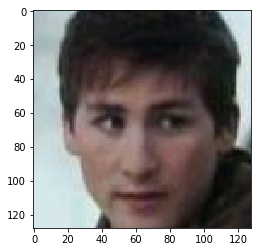

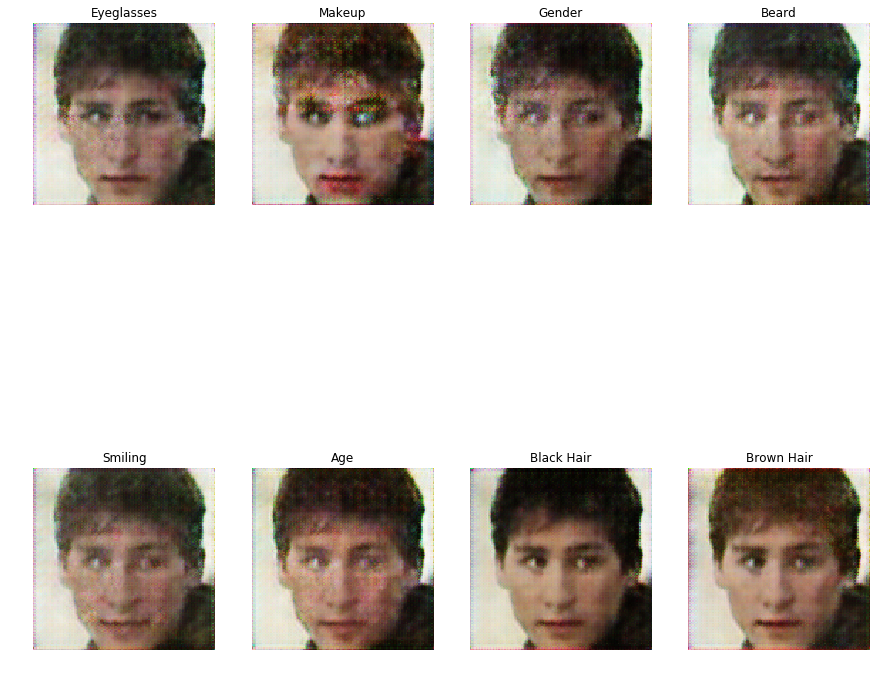

In [200]:
import copy

attr_name = ['Bald', 'Black Hair', 'Blond Hair', 'Brown Hair', 'Eyeglasses', 'Gray Hair', 
             'Makeup', 'Gender', 'Beard', 'Smiling', 'Wearing Hat', 'Age']

change_attr_list = [4, 6, 7, 8, 9, 11]
hair_attr_list = [1, 2, 3]

origin_idx = np.random.randint(len(celebA_list))

img_temp = cv2.imread(celebA_list[origin_idx])

data_x_test = np.zeros([1, img_size, img_size, 3])
data_x_test[0,:,:,:] = img_temp[45:45 + img_size, 25: 25+img_size, :]

attribute_origin_temp = Get_Attribute(origin_idx)    

attr_origin_test = np.zeros([1, img_size, img_size, attribute_size])
attr_origin_test[0,:,:,:] = attribute_origin_temp

plt.imshow(cv2.cvtColor(img_temp[45:45 + img_size, 25: 25+img_size, :], cv2.COLOR_BGR2RGB))

print("------------------------------Original Attribute------------------------------")
for k in range(len(attribute_origin_temp[0,0,0,:])):
    if attribute_origin_temp[0,0,0,k] == 1:
        print(attr_list_new[k])

f2, ax2 = plt.subplots(2,4, figsize=(15,15))

for i in range(len(change_attr_list)):
    change_idx = change_attr_list[i]

    attr_target_test = copy.deepcopy(attr_origin_test)
    
    if attribute_origin_temp[0,0,0,change_idx] == 0:
        attr_target_test[0,:,:,change_idx] = 1
    else:
        attr_target_test[0,:,:,change_idx] = 0
        
    G_out = sess.run(G, feed_dict = {x: data_x_test, attr_origin: attr_origin_test, 
                                  attr_target: attr_target_test, is_training: False})

    G_out = (G_out + 1.0)/2
    
    row = int(i/4)
    col = int(i%4)
    
    ax2[row][col].imshow(cv2.cvtColor(G_out[0], cv2.COLOR_BGR2RGB))
    ax2[row][col].axis('off')
    ax2[row][col].set_title(attr_name[change_idx])

for i in range(len(hair_attr_list)):
    hair_change_idx = hair_attr_list[i]
    
    if attr_origin_test[0,0,0,hair_change_idx] == 1:
        attr_origin_test[0,:,:,hair_change_idx] = 0
        del hair_attr_list[i]
        break

chosen_hair_list = np.random.choice(hair_attr_list, 2, replace=False)

for i in range(len(chosen_hair_list)):
    hair_idx = chosen_hair_list[i]
    
    attr_target_test = copy.deepcopy(attr_origin_test)
    
    attr_target_test[0,:,:,hair_idx] = 1
    
    G_out = sess.run(G, feed_dict = {x: data_x_test, attr_origin: attr_origin_test, 
                                  attr_target: attr_target_test, is_training: False})

    G_out = (G_out + 1.0)/2
    
    ax2[1][-2+i].imshow(cv2.cvtColor(G_out[0], cv2.COLOR_BGR2RGB))
    ax2[1][-2+i].axis('off')
    ax2[1][-2+i].set_title(attr_name[hair_idx])    

# Save Model

In [ ]:
if train_model:
    os.mkdir(save_path)

    Saver.save(sess, save_path + "/model/model")
    print("Model is saved in {}".format(save_path + "/model/model"))